In [1]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import polars as pl
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
start_time_utc = datetime.datetime.now()
print(f'Notebook Start Time (UTC): {start_time_utc}')

Notebook Start Time (UTC): 2024-09-11 11:25:32.647316


In [3]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        base_date = datetime.datetime(1900, 1, 1)
        for col in df.columns:
            if col[-1] in ("D",):
                days_since_base = (pl.col(col) - pl.lit(base_date)).dt.days()
                df = df.with_columns(
                 days_since_base.alias(col + "_days_since_1900_D")
                )
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.98:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 10000):
                    df = df.drop(col)
                elif freq>200:
                    top_20_frequency = (
                        df.group_by(col)
                          .agg(pl.count(col).alias("counts"))
                          .sort("counts", descending=True)
                          .head(20)
                    )
                    value_name = top_20_frequency[col].to_list()
                    sum_top_20 = top_20_frequency['counts'].sum()
                    total_non_null = df[col].count()
                    if sum_top_20 / total_non_null<0.7:
                        df=df.drop(col)
                        continue
                        
                    df = df.with_columns(
                        pl.when(pl.col(col).is_in(value_name)).then(pl.col(col)).otherwise(pl.lit(None)).alias(col)
                    )
        return df



class Aggregator:
    # Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_median = [pl.median(col).alias(f"median_{col}") for col in cols]
        expr_var = [pl.var(col).alias(f"var_{col}") for col in cols]
        expr_sum = [pl.sum(col).alias(f"sum_{col}") for col in cols]

        return expr_max + expr_last + expr_mean +expr_sum

    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_median = [pl.median(col).alias(f"median_{col}") for col in cols]

        return expr_max + expr_last + expr_mean 

    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        # expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return expr_max + expr_last  

    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return expr_max + expr_last

    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return expr_max + expr_last

    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs


In [4]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df


def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

In [5]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base


def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

In [8]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
df_train = df_train.pipe(Pipeline.filter_cols)
gc.collect()

train data shape:	 (1526659, 1062)


0

In [9]:
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)
nums=df_train.select_dtypes(exclude='category').columns
from itertools import combinations, permutations
#df_train=df_train[nums]
nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    # 计算列之间的相关性
    correlation_matrix = matrix.corr()

    # 分组列
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            #cross_features=list(combinations(Vs, 2))
            #make_corr(Vs)
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
            #make_corr(use)
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]
# df_train.drop(['requesttype_4525192L_cnt','max_empl_employedtotal_800L_cnt', 'max_empl_industry_691L_cnt'], axis=1, inplace=True)

Memory usage of dataframe is 8540.62 MB
Memory usage after optimization is: 3102.70 MB
Decreased by 63.7%
train data shape:	 (1526659, 877)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259D', 'max_num_group1_9']
####### NAN

In [10]:
# df_train.to_parquet('output.parquet', engine='pyarrow')

In [11]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target","case_id", "WEEK_NUM"])
# df_train, y = SMOTE().fit_resample(df_train, y)

In [12]:
nums=df_train.select_dtypes(exclude='category').columns
df_train[nums] = df_train[nums].fillna(0)

In [13]:
n_split = 5
cv = StratifiedGroupKFold(n_splits=n_split, shuffle=False)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.03,
    "n_estimators": 6000,  
    "reg_alpha": 0.4,
    "reg_lambda": 10,
    "colsample_bytree": 0.65,
    "colsample_bynode": 0.65,
    'num_leaves':64,
    "random_state": 42,
    "device": "cpu", 
    "verbose": -1,
    "scaled_pos_weight":20
}

fitted_models = []
cv_scores = []


for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#   Because it takes a long time to divide the data set, 
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    # case_id=X_valid['case_id']
    # X_valid=X_valid.drop(columns=['case_id'])
    # X_train=X_train.drop(columns=['case_id'])
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)] )
    fitted_models.append(model)
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
    
print("CV AUC scores: ", cv_scores)
print("AVG CV AUC score: ", np.mean(cv_scores))
print("Maximum CV AUC score: ", max(cv_scores))

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.846613
[400]	valid_0's auc: 0.853175
[600]	valid_0's auc: 0.855481
[800]	valid_0's auc: 0.856538
[1000]	valid_0's auc: 0.857143
[1200]	valid_0's auc: 0.857655
[1400]	valid_0's auc: 0.857835
Early stopping, best iteration is:
[1321]	valid_0's auc: 0.857858
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.845842
[400]	valid_0's auc: 0.852523
[600]	valid_0's auc: 0.854973
[800]	valid_0's auc: 0.856067
[1000]	valid_0's auc: 0.856743
[1200]	valid_0's auc: 0.857087
[1400]	valid_0's auc: 0.857291
[1600]	valid_0's auc: 0.857406
[1800]	valid_0's auc: 0.857433
Early stopping, best iteration is:
[1763]	valid_0's auc: 0.857471
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.85221
[400]	valid_0's auc: 0.858647
[600]	valid_0's auc: 0.861008
[800]	valid_0's auc: 0.862199
[1000]	valid_0's auc: 0.862726
[1200]	valid_0's auc: 0.863097
[1400]	valid_

In [14]:
best_idx = np.argmax(cv_scores)
best_idx

2

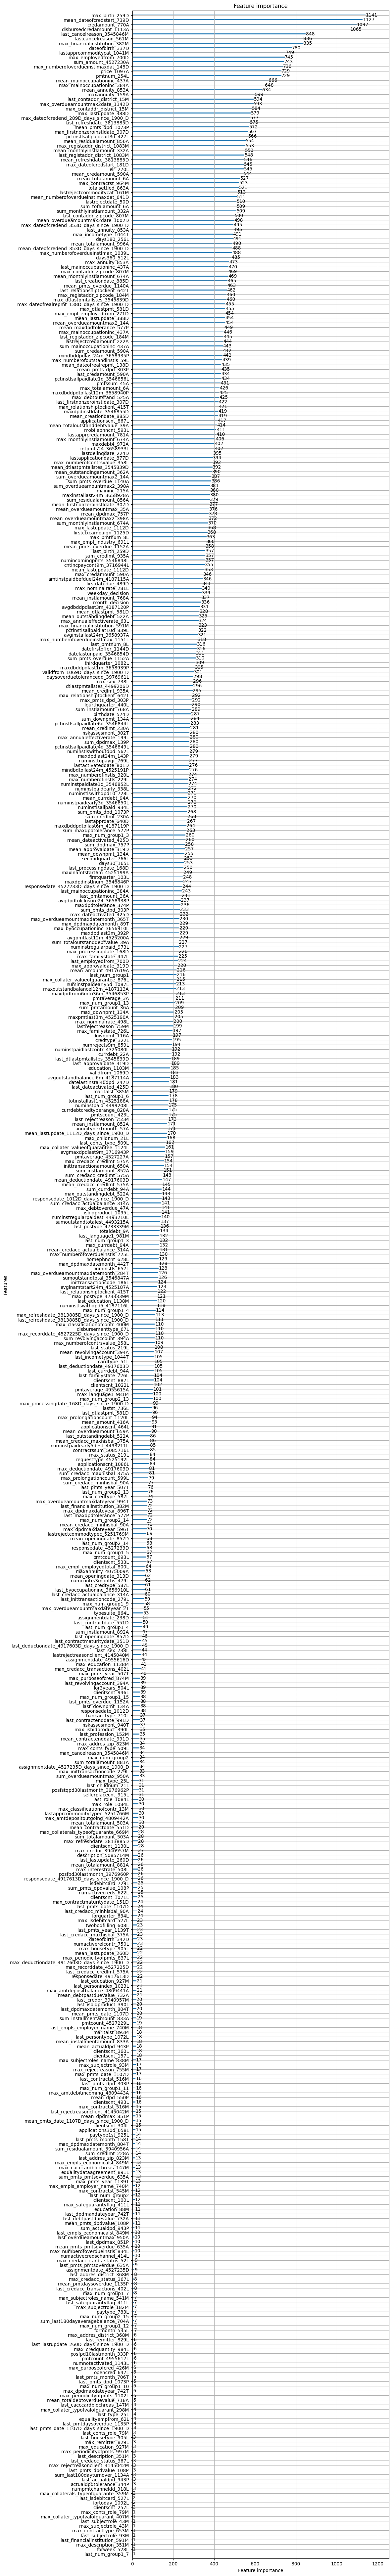

In [15]:
lgb.plot_importance(fitted_models[best_idx], importance_type="split", figsize=(10, 100))
plt.show()

In [16]:
best_model = fitted_models[best_idx]

# 获取Booster对象
booster = best_model.booster_

# 获取特征重要性
importances = booster.feature_importance(importance_type="split")

# 获取特征名称
feature_names = booster.feature_name()

# 将特征名称和重要性组合成字典
feature_importances_dict = dict(zip(feature_names, importances))

# 打印字典
less_important_features = [key for key, value in feature_importances_dict.items() if value ==0]

print(less_important_features)

for key, value in feature_importances_dict.items():
    if key.endswith('M') and key.startswith('max'):
        print(f"{key}: {value}")

['applicationcnt_361L', 'deferredmnthsnum_166L', 'sum_installmentamount_644A', 'sum_residualamount_1093A', 'for3years_128L', 'for3years_584L', 'formonth_118L', 'formonth_206L', 'forquarter_1017L', 'forquarter_462L', 'forweek_1077L', 'forweek_601L', 'foryear_818L', 'commnoinclast6m_3546845L', 'mastercontrelectronic_519L', 'mastercontrexist_109L', 'mean_outstandingamount_354A', 'mean_overdueamount_31A', 'max_pmts_month_158T', 'max_residualamount_488A', 'mean_totaloutstanddebtvalue_668A', 'sum_outstandingamount_354A', 'sum_totaldebtoverduevalue_718A', 'sum_residualamount_488A', 'sum_totaloutstanddebtvalue_668A', 'max_numberofoutstandinstls_520L', 'max_installmentamount_644A', 'max_num_group1_8', 'last_num_group1_8', 'sum_last30dayturnover_651A', 'last_pmts_overdue_1140A', 'max_pmts_month_706T', 'max_profession_152M', 'last_classificationofcontr_13M', 'last_classificationofcontr_400M', 'last_contractst_545M', 'last_contractst_964M', 'last_purposeofcred_426M', 'last_purposeofcred_874M', 'la

In [17]:
import joblib

joblib.dump(fitted_models, 'lgb_models.joblib')

notebook_info = {
    'notebook_start_time': start_time_utc,
    'description': 'Add notebook info dict to store cols and cat_cols',
    'cols': df_train.columns.to_list(),
    'cat_cols': cat_cols,
}
joblib.dump(notebook_info, 'notebook_info.joblib')

['notebook_info.joblib']

In [18]:
!ls -al

total 62560
drwxr-xr-x 2 root root     4096 Sep 11 16:33 .
drwxr-xr-x 6 root root     4096 Sep 11 11:25 ..
---------- 1 root root  2928249 Sep 11 16:33 __notebook__.ipynb
-rw-r--r-- 1 root root 61101985 Sep 11 16:33 lgb_models.joblib
-rw-r--r-- 1 root root    16626 Sep 11 16:33 notebook_info.joblib


In [19]:
print("CV AUC scores: ", cv_scores)
print("AVG CV AUC score: ", np.mean(cv_scores))
print("Maximum CV AUC score: ", max(cv_scores))

CV AUC scores:  [0.8578577643618053, 0.8574711852886001, 0.8636884982403747, 0.8625396858426144, 0.8587179124992752]
AVG CV AUC score:  0.860055009246534
Maximum CV AUC score:  0.8636884982403747
